In [ ]:
# # over all process
# 1 - Data Flow from Generator

# Generator creates batches:

# Your image_dataset_from_directory (or any generator) doesn’t load all images into memory at once.

# It reads a small batch of images (e.g., 32 images) from disk.

# Each image is resized to 256×256 and converted to 3 channels (RGB).

# Each batch is paired with its labels (0 for cat, 1 for dog).

# Batch is sent to the model:

# The model receives the batch as a 4D tensor: (batch_size, 256, 256, 3)

# Example: (32, 256, 256, 3) → 32 images in the batch.

# 2 - Conv2D layers:

# Each convolution layer extracts local features like edges, textures, and patterns.

# Filters slide over the image to create feature maps.

# Batch Normalization:

# Normalizes each feature map across the batch.

# Keeps inputs to the next layer stable → faster, more reliable learning.

# Activation (ReLU):

# Introduces non-linearity → model can learn complex patterns.

# MaxPooling:

# Reduces spatial dimensions (height & width), keeping important features.

# Helps reduce overfitting and computation.

# Dropout (if used):

# Randomly turns off some neurons during training.

# Prevents the network from memorizing training data, reducing overfitting.

# This process repeats for 3–4 Conv2D blocks, gradually extracting higher-level features (from edges → textures → shapes → object-level patterns).

# 3 - Flatten & Dense Layers

# Flatten:

# Converts 3D feature maps into a 1D vector so it can be fed to fully connected layers.

# Dense layers:

# Learn combinations of features that best separate cats vs dogs.

# Dropout is applied here too → more regularization.

# Output layer (sigmoid):

# Produces a probability between 0 and 1:

# Close to 0 → cat

# Close to 1 → dog

# 3 - Backpropagation & Optimization

# Loss calculation:

# Compare predicted probability vs true label (binary cross-entropy loss).

# Gradient calculation:

# Compute gradients of loss w.r.t all weights in the model.

# Adam optimizer updates weights:

# Adjusts filters in Conv2D and weights in Dense layers to reduce loss.

# Repeat for next batch:

# Generator provides the next batch → forward + backward pass again.

# 4 - Epochs & Validation

# One epoch = every training image has been seen once (in batches).

# Validation data is also processed in batches:

# Forward pass only (no weight updates)

# Gives validation accuracy after each epoch.

In [2]:
path_train = '/content/drive/MyDrive/Data/CatsAndDogs/training_set/training_set'
path_test = '/content/drive/MyDrive/Data/CatsAndDogs/test_set/test_set'

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import  Conv2D , Dense, MaxPooling2D, Flatten , Input , BatchNormalization , Dropout

In [4]:
%%capture
def remove_corrupted_with_tf(folder):
    count_removed = 0
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg')):
                fpath = os.path.join(root, fname)
                try:
                    raw = tf.io.read_file(fpath)
                    _ = tf.io.decode_jpeg(raw)  # will raise InvalidArgumentError if broken
                except Exception as e:
                    print(f"❌ Removing corrupted image: {fpath} ({e})")
                    try:
                        os.remove(fpath)
                        count_removed += 1
                    except:
                        pass
remove_corrupted_with_tf(path_train)

NameError: name 'os' is not defined

In [5]:
# Generators process large data in batches and contain only that batch size in RAM (doesnot crash at runtime)
train_ds = keras.utils.image_dataset_from_directory(
    directory = path_train,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256),
    color_mode='rgb'
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = path_test,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256),
    color_mode='rgb'
)

Found 24804 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [6]:
def preprocess(img, label):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [256, 256])

    img = tf.image.grayscale_to_rgb(img) if tf.shape(img)[-1] == 1 else img
    img = tf.cond(tf.shape(img)[-1] == 2,
                  lambda: tf.image.grayscale_to_rgb(img[..., :1]),
                  lambda: img)
    return img, label


In [7]:
# I trained the model with 4 Conv2D blocks, each having Batch Normalization, MaxPooling, and Dropout for
# better feature extraction and regularization. This is followed by flattening and passing through two Dense layers
# with Dropout before the final sigmoid output for binary classification. The model trains with Adam (lr=0.0003) and
# achieved 88% accuracy on the validation data. Thanks Nitish!


model = Sequential()
model.add(Input(shape = (256, 256 , 3)))

# cnn layer 1
model.add(Conv2D(32 ,   kernel_size=(3,3), padding = 'valid' , activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0,1))
model.add(MaxPooling2D(pool_size = (2,2) , strides = 2 , padding = 'valid'))

# cnn layer 2
model.add(Conv2D(64 ,   kernel_size=(3,3), padding = 'valid' , activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size = (2,2) , strides = 2 , padding = 'valid'))

# cnn layer 3
model.add(Conv2D(128 ,   kernel_size=(3,3), padding = 'valid' , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2) , strides = 2 , padding = 'valid'))

# cnn layer 4
# model.add(Conv2D(256 ,   kernel_size=(3,3), padding = 'valid' , activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size = (2,2) , strides = 2 , padding = 'valid'))

# flatten
model.add(Flatten())

# Ann part
# fully connected layer
model.add(Dense(128 , activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64 ,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))



In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
model.compile(optimizer='adam' , loss='binary_crossentropy' , metrics = ['accuracy'])

In [10]:
history = model.fit(train_ds , epochs = 10 , validation_data=test_ds)

Epoch 1/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 3298s 4s/step - accuracy: 0.5752 - loss: 2.2676 - val_accuracy: 0.6500 - val_loss: 0.7514
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 127s 127ms/step - accuracy: 0.7285 - loss: 0.5602 - val_accuracy: 0.7153 - val_loss: 0.5426
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 97s 125ms/step - accuracy: 0.7782 - loss: 0.4671 - val_accuracy: 0.7316 - val_loss: 0.5046
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 144s 127ms/step - accuracy: 0.8236 - loss: 0.3905 - val_accuracy: 0.6881 - val_loss: 0.6825
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 141s 125ms/step - accuracy: 0.8530 - loss: 0.3332 - val_accuracy: 0.8833 - val_loss: 0.3001
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 138s 121ms/step - accuracy: 0.8892 - loss: 0.2638 - val_accuracy: 0.9090 - val_loss: 0.2496
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 149s 129ms/step - accuracy: 0.9273 - loss: 0.1854 - val_accuracy: 0.9001 - val_loss: 0.2343
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 98s 126ms/step - accuracy: 0.9504 - los

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from tensorflow import keras
keras.models.save_model(model , '/content/drive/MyDrive/Colab Notebooks/CatAndDog.keras')

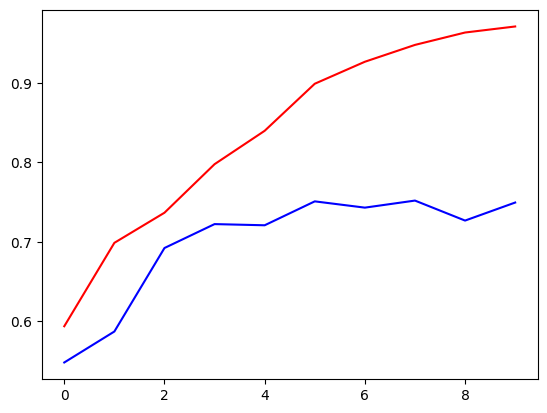

In [ ]:
# old one
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'] , color = 'red' , label = 'train')
plt.plot(history.history['val_accuracy'] , color = 'blue' , label = 'test')


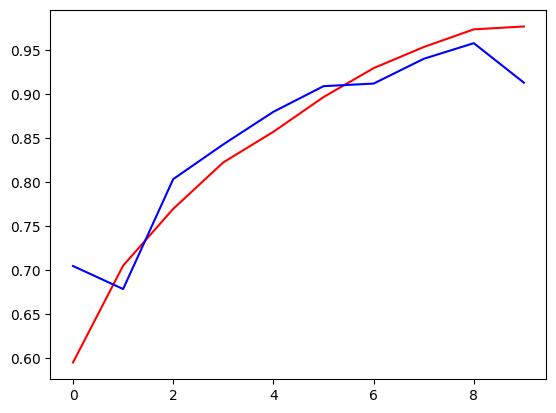

In [ ]:
# old one
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'] , color = 'red' , label = 'train')
plt.plot(history.history['val_accuracy'] , color = 'blue' , label = 'test')


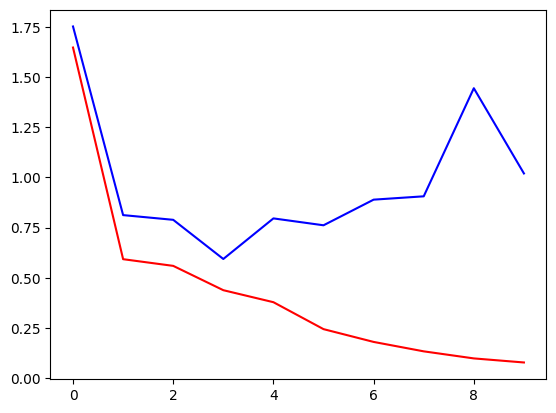

In [ ]:
# old
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , color = 'red' , label = 'train')
plt.plot(history.history['val_loss'] , color = 'blue' , label = 'test')

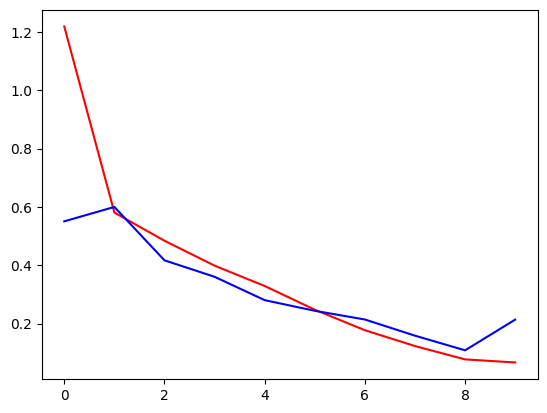

In [ ]:
# old
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , color = 'red' , label = 'train')
plt.plot(history.history['val_loss'] , color = 'blue' , label = 'test')

In [16]:
model_test = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CatAndDog.keras')

In [17]:
import cv2
test_image = cv2.imread('/content/dog.jpeg')

In [18]:
# testing on unseen input
test_image = cv2.resize(test_image ,(256,256))
test_input = test_image.reshape((1,256,256,3))
prediction = model_test.predict(test_input)

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [1]:
pred_class = (prediction > 0.5).astype(int)
print(prediction)
if pred_class[0][0] == 1:
  print("Dog")
else:
  print("Cat")

NameError: name 'prediction' is not defined